This is the continuation of the notebook `customer_lead_generator_eda.ipynb`.

In [1]:
!pip install imblearn

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline # don't overwrite sklearn's "vanilla" Pipeline
from imblearn.over_sampling import SMOTE # for oversampling the minority class, i.e generating synthetic samples

import matplotlib.pyplot as plt
import seaborn as sns

import os

__Helper functions__

Function to plot the ROC curve, calculate AUC for a base model and the AUC of our model.

In [3]:
def plot_roc(y_test, proba_preds, model_name):

    # create linear line for dummy classifier with 50% random probability of predictions
    base_probs = [0 for _ in range(len(y_test))] # 0 is the majority class, could also sample randomly
    base_auc = roc_auc_score(y_test, base_probs)

    # get auc for ML model
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) # roc curve for the dummy model (3rd output: threshold, not using for plotting)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds) # roc curve for your model

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Function to plot test scores. Chossing F1 score of minority class, because our data is very imbalanced and we want to optimize the prediction of the minority class (1):
*   **`b_gekauft_gesamt`** (whether a purchase was made):
    *   No Purchase (0): 98.49%
    *   Purchase (1): 1.51%

In [4]:
def plot_scores(scores):
    scores_df = pd.DataFrame({
        'model': scores.keys(), 'F1 score of minority class': scores.values()
    })
    scores_df = scores_df.sort_values('F1 score of minority class', ascending=True).set_index("model")
    f, ax = plt.subplots(figsize=(10,10)) 
    scores_df.plot(kind="barh", ax=ax);

## 3. Model Development

### Import the P
rocessed data

In [5]:
data_folder = 'data'
filename = 'CustomerData_LeadGenerator.csv'

clean_filename = filename.replace('.csv', '_clean.csv')
customer_data_path_clean = os.path.join(data_folder, clean_filename)

clean_reduced_filename = filename.replace('.csv', '_clean_reduced.csv')
customer_data_path_clean_reduced = os.path.join(data_folder, clean_reduced_filename)

df = pd.read_csv(customer_data_path_clean, index_col=0)
df.head()

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,...,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_gekauft_gesamt
0,0,0,0,0,0,0,0,0,0,1,...,195228,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1
1,0,0,0,1,1,1,0,0,0,0,...,168291,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1
2,0,0,0,1,0,1,0,0,0,1,...,189787,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1
3,0,1,1,0,0,0,0,0,0,0,...,189634,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,0
4,0,0,0,0,0,1,0,0,0,1,...,207590,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1


In [6]:
df_reduced = pd.read_csv(customer_data_path_clean_reduced, index_col=0)
df_reduced

,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,q_Uni by Total Pop,q_2017 Medical Products: Per Capita,b_gekauft_gesamt
0,0,0,0,0,0,0,0,0,0,1,4,36.0,2.1,0.186735,23730.35,2194057,0.147971,326.28,1
1,0,0,0,1,1,1,0,0,0,0,4,20.0,2.1,0.179848,23343.26,1966798,0.142938,320.36,1
2,0,0,0,1,0,1,0,0,0,1,0,0.0,2.1,0.184935,23674.18,2149624,0.149015,325.57,1
3,0,1,1,0,0,0,0,0,0,0,4,20.0,2.1,0.184523,23572.26,2161445,0.143876,324.06,0
4,0,0,0,0,0,1,0,0,0,1,5,33.0,2.1,0.189871,23821.63,2302959,0.145439,327.75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,0,0,0,0,0,0,0,0,0,0,0,0.0,2.2,0.203542,23869.52,327760,0.125418,325.57,0
3769,0,0,0,0,0,0,0,0,0,1,0,0.0,2.1,0.184899,23677.97,2150320,0.149148,326.32,0
3770,0,0,0,0,0,0,0,0,0,0,0,0.0,2.1,0.186292,23721.89,2167556,0.149137,326.22,0
3771,0,0,0,0,0,0,0,0,0,1,0,0.0,2.2,0.222034,24711.33,328260,0.116490,342.68,0


### Logistic Regression Model using Reduced Data
#### Train - test split
Using 80% of the data for training the model and the remaining 20% for testing.

In [7]:
target = "b_gekauft_gesamt"
df_reduced_train, df_reduced_test = train_test_split(
    df_reduced, test_size=0.2, random_state=5, stratify=df_reduced[target])
# without stratify=y the class proportions might shift a bit - ensures equal class proportions
df_reduced_train.shape, df_reduced_test.shape

((3018, 19), (755, 19))

In [8]:
X_reduced_train = df_reduced_train.drop(columns=[target])
y_train = df_reduced_train[target]
X_reduced_test = df_reduced_test.drop(columns=[target])
y_test = df_reduced_test[target]
X_reduced_train.shape, X_reduced_test.shape, y_train.shape, y_test.shape

((3018, 18), (755, 18), (3018,), (755,))

In [9]:
# Check how balanced our data is
y_train.value_counts()

0    2972
1      46
Name: b_gekauft_gesamt, dtype: int64

In [10]:
y_test.value_counts()

0    744
1     11
Name: b_gekauft_gesamt, dtype: int64

Since there are only 46 positive samples in the training set, undersampling the majority class is not an option. Let's try:
1. Rebalancing the data using class weighting
2. Oversampling the minority class using SMOTE - Synthetic Over-Sampling

#### Logistic Regression model using class weights
* Using class_weight = ‘balanced’, as the dataset is unbalanced
* Using solver = 'lbfgs' because it works for no penalty Logistic Regression

In [11]:
model_logreg = LogisticRegression(
    class_weight="balanced", solver="lbfgs", penalty=None, random_state=42, max_iter=1000
)
model_logreg

LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None,
                   random_state=42)

In [12]:
model_logreg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': None,
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

* Define Numeric Transformer and Logistic Regression Pipeline
* Since we have only numeric features, we simply use `KNNImputer` for missing values imputation and `StandardScaler` for scaling
* If we would have categorical features, we would need to
  1) separate features by type,
  2) in one `Pipeline`, fill missing values using `SimpleImputer` and transform categorical features into integers using `OneHotEncoder`,
  3) in other `Pipeline`, transform numerical features using `KNNImputer` and `StandardScaler`,
  4) combine the two pipelines into one using `ColumnTransformer` and, finally,
  5) add it as the first step in the final `Pipeline` for modelling.

In [13]:
pipeline_logreg = Pipeline(steps=[
    ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
    ("scaler", StandardScaler().set_output(transform="pandas")),
    ("classifier", model_logreg)
])

pipeline_logreg

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty=None, random_state=42))])

In [14]:
scores = {} # dictionary to store F1 scores of all compared models
model_name_reduced = "Logistic Regression with Class Weights (X_reduced)"

pipeline_logreg.fit(X_reduced_train, y_train)
pred_logreg_reduced = pipeline_logreg.predict(X_reduced_test)
scores[model_name_reduced] = f1_score(y_test, pred_logreg_reduced) # it is F1 score of the minority class

In [15]:
print(classification_report(y_test, pred_logreg_reduced))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       744
           1       0.04      0.73      0.08        11

    accuracy                           0.76       755
   macro avg       0.52      0.75      0.47       755
weighted avg       0.98      0.76      0.85       755



In [16]:
print(confusion_matrix(y_test, pred_logreg_reduced, labels=[0, 1]))

[[569 175]
 [  3   8]]


Logistic: ROC AUC=0.780


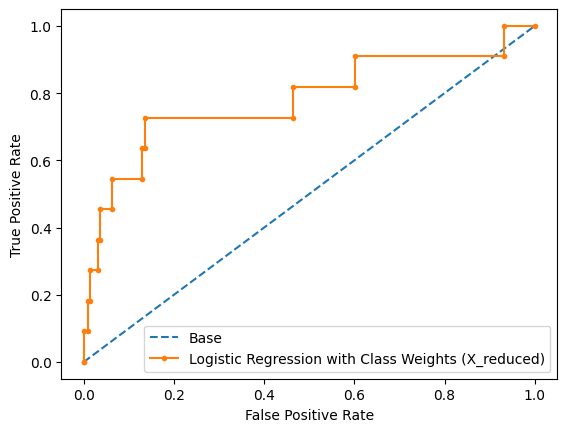

In [17]:
proba_preds_logreg_reduced = pipeline_logreg.predict_proba(X_reduced_test)[:, 1]
plot_roc(y_test, proba_preds_logreg_reduced, model_name=model_name_reduced)

#### Logistic Regression Model using SMOTE - Synthetic Over-Sampling

In [18]:
pipeline_smote_logreg = ImbPipeline(steps=[
    ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
    ("scaler", StandardScaler().set_output(transform="pandas")),
    ("smote", SMOTE(random_state=42)), # this step is only in imblearn.pipeline's Pipeline
    ("classifier", model_logreg)
                              ])
pipeline_smote_logreg

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    penalty=None, random_state=42))])

In [19]:
# Checking the upsampling
pipeline_smote_logreg[:3]

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=42))])

In [20]:
X_train_res, y_train_res = pipeline_smote_logreg[:3].fit_resample(X_reduced_train, y_train)
y_train_res.value_counts() # now 1 label is as frequent as 0

0    2972
1    2972
Name: b_gekauft_gesamt, dtype: int64

In [21]:
y_train.value_counts() # before upsampling

0    2972
1      46
Name: b_gekauft_gesamt, dtype: int64

In [22]:
model_name_smote_reduced = "Logistic Regression with SMOTE (X_reduced)"

pipeline_smote_logreg.fit(X_reduced_train, y_train)
pred_logreg_smote_reduced = pipeline_smote_logreg.predict(X_reduced_test)
scores[model_name_smote_reduced] = f1_score(y_test, pred_logreg_smote_reduced) # it is F1 score of the minority class

In [23]:
print(classification_report(y_test, pred_logreg_smote_reduced))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       744
           1       0.04      0.73      0.08        11

    accuracy                           0.74       755
   macro avg       0.52      0.73      0.46       755
weighted avg       0.98      0.74      0.84       755



In [24]:
print(confusion_matrix(y_test, pred_logreg_smote_reduced, labels=[0, 1]))

[[550 194]
 [  3   8]]


Logistic: ROC AUC=0.759


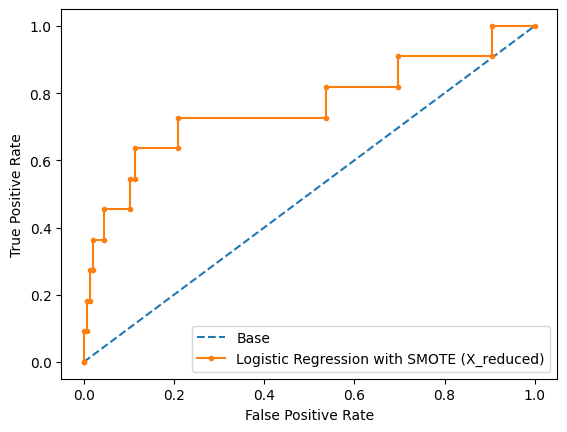

In [25]:
proba_preds_logreg_smote_reduced = pipeline_smote_logreg.predict_proba(X_reduced_test)[:, 1]
plot_roc(y_test, proba_preds_logreg_smote_reduced, model_name=model_name_smote_reduced)

### Logistic Regression Model using Full Data
#### Train - test split

In [26]:
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=5, stratify=df[target])
df_train.shape, df_test.shape

((3018, 24), (755, 24))

In [27]:
X_train = df_train.drop(columns=[target])
#y_train = df_train[target] #same as before
X_test = df_test.drop(columns=[target])
#y_test = df_test[target] #same as before
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3018, 23), (755, 23), (3018,), (755,))

#### Logistic Regression Model using Class Weights

In [28]:
model_name = "Logistic Regression with Class Weights (X full)"

pipeline_logreg.fit(X_train, y_train)
pred_logreg = pipeline_logreg.predict(X_test)
scores[model_name] = f1_score(y_test, pred_logreg)

In [29]:
print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       744
           1       0.04      0.73      0.08        11

    accuracy                           0.76       755
   macro avg       0.52      0.74      0.47       755
weighted avg       0.98      0.76      0.85       755



In [30]:
print(confusion_matrix(y_test, pred_logreg, labels=[0, 1]))

[[563 181]
 [  3   8]]


Logistic: ROC AUC=0.772


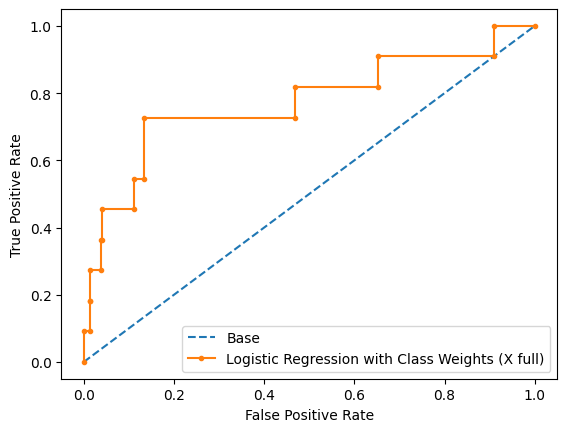

In [31]:
proba_preds_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]
plot_roc(y_test, proba_preds_logreg, model_name=model_name)

### Compare model performance

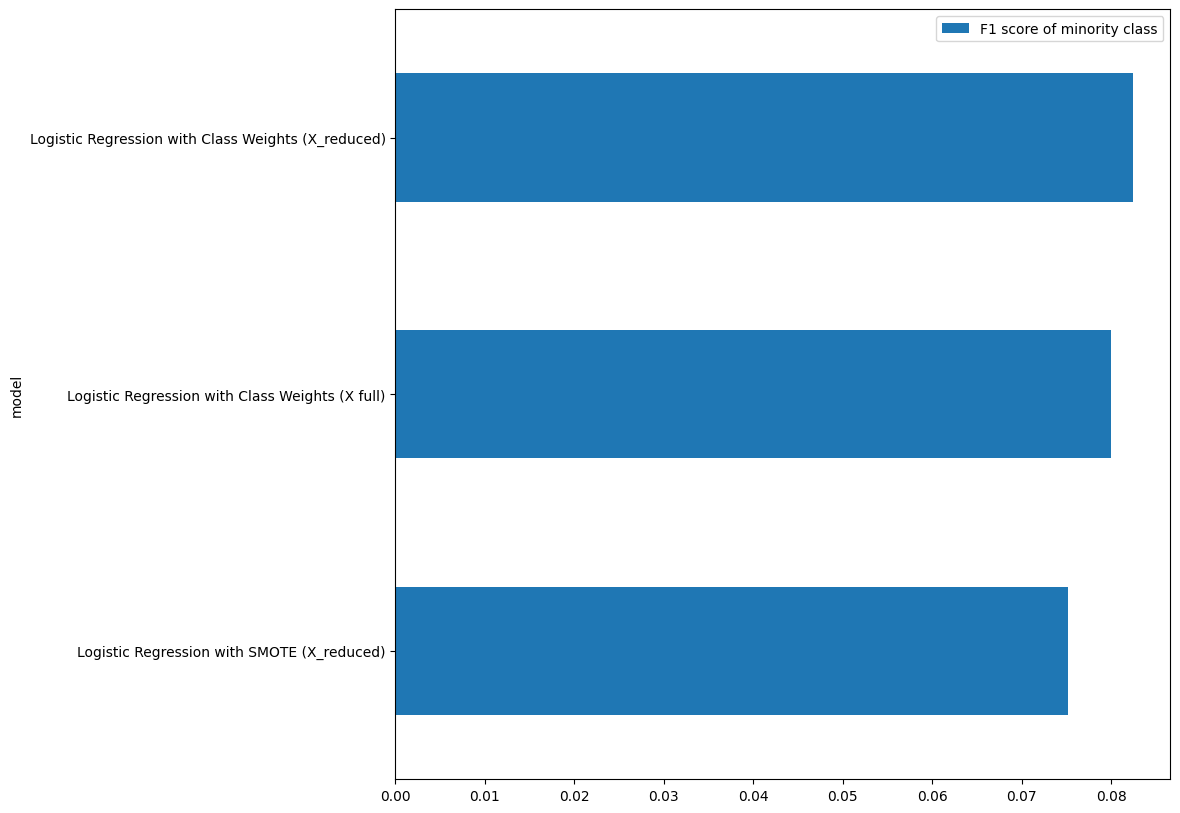

In [32]:
plot_scores(scores)

__Conclusion__
* Logistic regression model using SMOTE performes worse for the majority class and the same for the minority class compared to using class weights.
* Logistic regression model using full data performes comparable to the same model but using reduced data.
* Will not try undersamling because there is already very little data for the minority label (46 samples).
* It's time to try a tree-based model, which is more robust to class imbalance.

#### Random Forest Classifier using Full Data

In [33]:
rfc = RandomForestClassifier(class_weight="balanced", # does not work (nothing predicted as '0', UndefinedMetricWarning)
                             n_estimators=500, random_state=42)
# Tree-based models do not require scaling
pipeline_rfc = Pipeline([
    ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
    ("scaler", StandardScaler().set_output(transform="pandas")), # scaling is not necessary for tree-based models, tried both
    ("classifier", rfc)
])
pipeline_rfc

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, random_state=42))])

In [34]:
model_name = "RandomForestClassifier (X full)"

pipeline_rfc.fit(X_train, y_train)
pred_rfc = pipeline_rfc.predict(X_test)
scores[model_name] = f1_score(y_test, pred_rfc)

In [35]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       0.00      0.00      0.00        11

    accuracy                           0.99       755
   macro avg       0.49      0.50      0.50       755
weighted avg       0.97      0.99      0.98       755



/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [36]:
print(confusion_matrix(y_test, pred_rfc, labels=[0, 1]))

[[744   0]
 [ 11   0]]


Logistic: ROC AUC=0.717


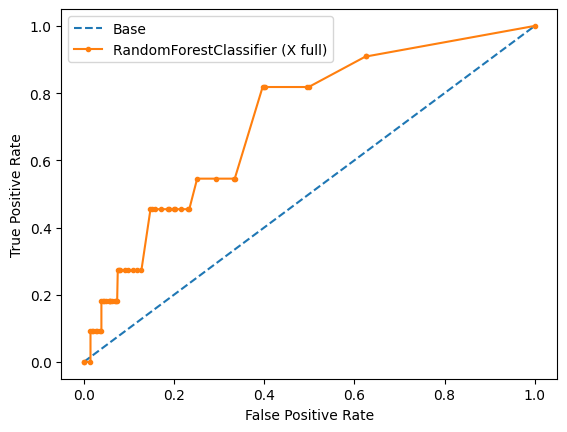

In [37]:
proba_preds_rfc = pipeline_rfc.predict_proba(X_test)[:, 1]
plot_roc(y_test, proba_preds_rfc, model_name=model_name)

#### Feature importance from the RandomForest Model

Trees based models like RandomForest, XGBoost, etc. provide us feature importance based on the training.

In [38]:
rfc.feature_importances_

array([0.01920502, 0.00719583, 0.01076128, 0.03103347, 0.03521613,
       0.0246792 , 0.00073201, 0.00612808, 0.00807296, 0.02308956,
       0.02171691, 0.05349265, 0.01785496, 0.06441284, 0.0636319 ,
       0.06985555, 0.07089115, 0.05743218, 0.07305234, 0.07943268,
       0.09729021, 0.08131025, 0.08351284])

In [39]:
rfc_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": np.round(rfc.feature_importances_, 3)}
)
rfc_importances = rfc_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)
rfc_importances

,importance
feature,
b_specialisation_c,0.001
b_specialisation_b,0.006
b_specialisation_h,0.007
b_specialisation_a,0.008
b_specialisation_g,0.011
q_2017 Average Household Size,0.018
b_specialisation_i,0.019
q_OpeningDays,0.022
b_specialisation_j,0.023


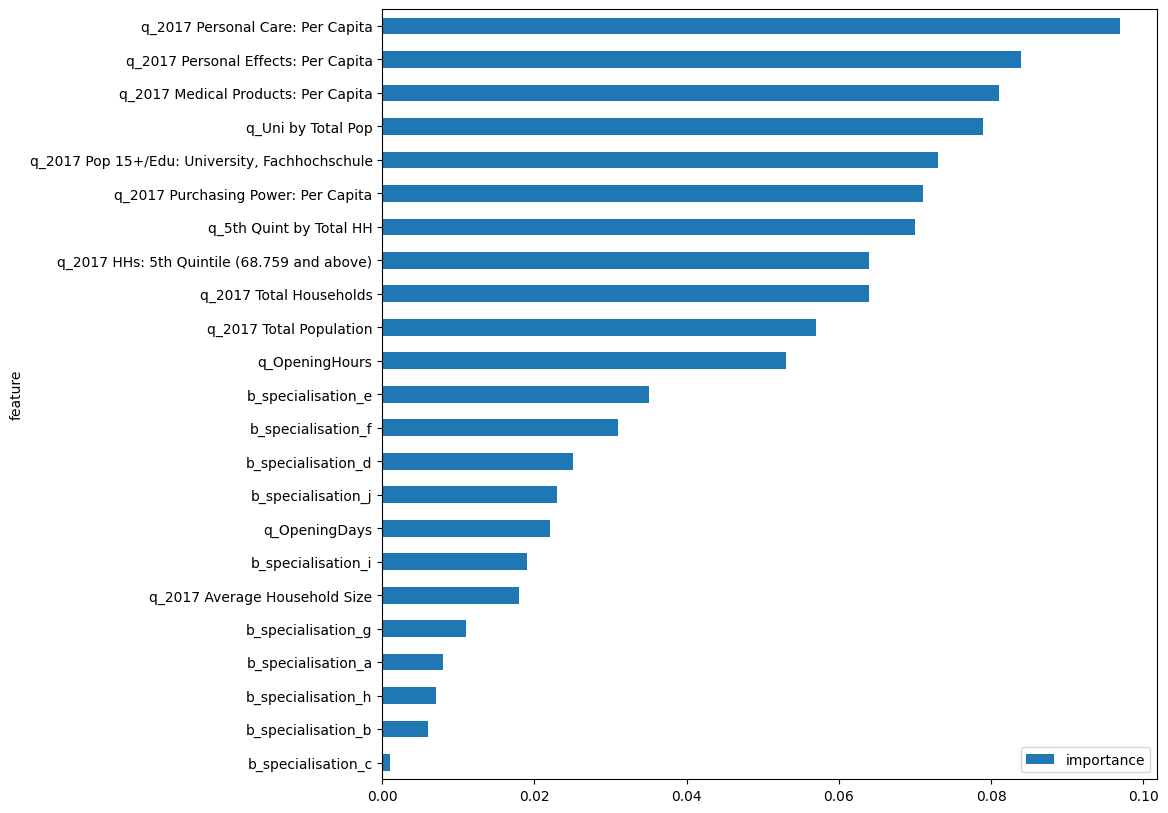

In [40]:
f, ax = plt.subplots(figsize=(10, 10)) 
rfc_importances.plot(kind="barh",ax=ax);

#### XGBoost Classifier using Full Data

In [41]:
# scale_pos_weight parameter calcution: sum(negative instances) / sum(positive instances)
y_train.value_counts()[0] / y_train.value_counts()[1]

64.6086956521739

In [42]:
xgb = XGBClassifier(scale_pos_weight=65, n_estimators=500, random_state=42)
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [43]:
pipeline_xgb = Pipeline([("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
                         ("scaler", StandardScaler()),
                         ("model", xgb)])
pipeline_xgb

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [44]:
model_name = "XGBoost (X full)"

pipeline_xgb.fit(X_train, y_train)
pred_xgb = pipeline_xgb.predict(X_test)
scores[model_name] = f1_score(y_test, pred_rfc)

In [45]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       744
           1       0.00      0.00      0.00        11

    accuracy                           0.99       755
   macro avg       0.49      0.50      0.50       755
weighted avg       0.97      0.99      0.98       755



/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ria/apps/miniconda3/envs/MLG/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [46]:
print(confusion_matrix(y_test, pred_rfc, labels=[0, 1]))

[[744   0]
 [ 11   0]]


Logistic: ROC AUC=0.658


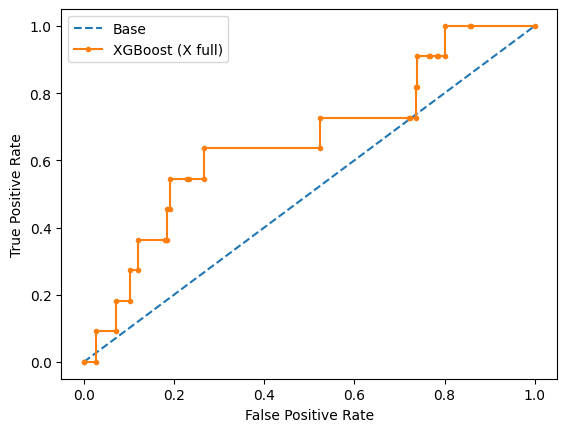

In [47]:
proba_preds_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
plot_roc(y_test, proba_preds_xgb, model_name=model_name)

#### Feature importance from the XGBoost Model

In [49]:
xgb.feature_importances_

array([0.09001559, 0.03533258, 0.02505949, 0.07553358, 0.21648453,
       0.1297177 , 0.        , 0.0247237 , 0.02610716, 0.03769668,
       0.01818496, 0.02305949, 0.00394311, 0.03522763, 0.02395237,
       0.0098686 , 0.01650915, 0.02144909, 0.05093203, 0.01823268,
       0.05473837, 0.02530329, 0.03792832], dtype=float32)

In [50]:
xgb_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": np.round(xgb.feature_importances_, 3)}
)
xgb_importances = xgb_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)
xgb_importances

,importance
feature,
b_specialisation_c,0.000
q_2017 Average Household Size,0.004
q_5th Quint by Total HH,0.010
q_2017 Purchasing Power: Per Capita,0.017
q_Uni by Total Pop,0.018
q_OpeningDays,0.018
q_2017 Total Population,0.021
q_OpeningHours,0.023
q_2017 HHs: 5th Quintile (68.759 and above),0.024


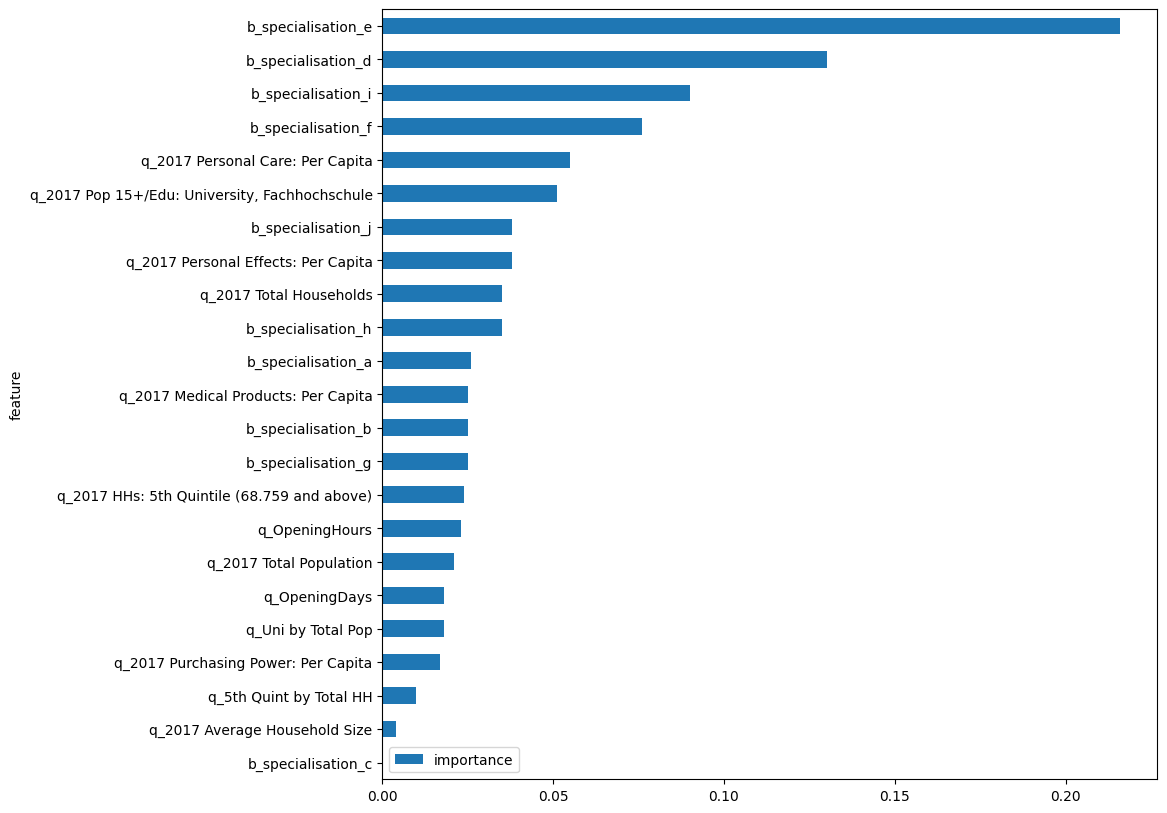

In [51]:
f, ax = plt.subplots(figsize=(10, 10)) 
xgb_importances.plot(kind="barh",ax=ax);

### Conclusions
* Most of the features have low importance scores and their order by importance is different between Random Forest and XgBoost.
* The low performance of the models with balancing techniques on the minority class and the low feature importances indicate that the data might have been synthetically generated.
* One approach that usually help to improve the performance is to to reduce the features based on their importance and then train models using only the more important features.
* Next, I am selecting features with XGboost-importance above 0.02 based on the plot above and using them to train multiple classification models using low-code library, PyCaret, in the following notebook: `customer_lead_generator_modelling_pycaret.ipynb`.
* I also tried to do automatic feature reduction based on multicollinearity using PyCaret, but no model was significantly better then logistic regression models trained above.
* Besides the high class imbalance, another problem with the data is small sample size, especially for the minority class. Increasing the sample size would improve the ability of the modelling algorithms to learn patterns from the data and better generalize to new data, leading to more accurate predictions.

In [52]:
important_features = xgb_importances[xgb_importances.importance > 0.02].sort_values("importance", ascending=False)
print(len(important_features))
important_features

17


,importance
feature,
b_specialisation_e,0.216
b_specialisation_d,0.130
b_specialisation_i,0.090
b_specialisation_f,0.076
q_2017 Personal Care: Per Capita,0.055
"q_2017 Pop 15+/Edu: University, Fachhochschule",0.051
q_2017 Personal Effects: Per Capita,0.038
b_specialisation_j,0.038
q_2017 Total Households,0.035


In [53]:
# Select only those important columns in train and test set
columns = important_features.index.values
X_train_selected = X_train.loc[:, columns]
X_train_selected.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population
1475,1,0,0,0,592.36,322983,234.87,0,1047901,1,0,325.87,0,1,193787,20.0,2198616
65,0,0,0,0,589.09,69464,237.50,0,211946,0,0,326.34,0,1,42641,0.0,454573
2226,1,0,0,0,590.05,291043,232.02,1,962669,1,0,323.33,0,1,173260,0.0,2015517
2034,1,0,1,1,564.32,18344,238.39,0,109185,0,0,330.21,0,0,22659,27.0,254994
2643,0,0,0,0,592.58,38724,252.89,0,151203,0,0,341.76,0,0,33686,20.0,335485


In [54]:
X_test_selected = X_test.loc[:, columns]
X_test_selected.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population
742,1,0,0,0,536.11,1311,213.21,0,13766,1,0,318.80,0,0,2193,27.0,32416
592,0,0,0,0,589.14,295134,229.28,0,940947,0,0,320.47,0,0,165741,29.5,1962729
112,0,0,0,0,593.74,334839,237.38,1,1085613,0,0,327.78,0,0,205969,0.0,2285107
3408,0,0,0,0,543.27,4057,230.41,0,31967,0,0,333.26,0,0,6289,20.0,76357
3567,1,0,1,1,581.46,70850,235.25,1,230364,0,0,323.27,0,1,46642,0.0,503689


In [55]:
# Join the labels and save as CSV files
train_data = pd.concat([X_train_selected, y_train], axis=1)
train_data.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population,b_gekauft_gesamt
1475,1,0,0,0,592.36,322983,234.87,0,1047901,1,0,325.87,0,1,193787,20.0,2198616,0
65,0,0,0,0,589.09,69464,237.50,0,211946,0,0,326.34,0,1,42641,0.0,454573,1
2226,1,0,0,0,590.05,291043,232.02,1,962669,1,0,323.33,0,1,173260,0.0,2015517,0
2034,1,0,1,1,564.32,18344,238.39,0,109185,0,0,330.21,0,0,22659,27.0,254994,0
2643,0,0,0,0,592.58,38724,252.89,0,151203,0,0,341.76,0,0,33686,20.0,335485,0


In [56]:
test_data = pd.concat([X_test_selected, y_test], axis=1)
test_data.head()

,b_specialisation_e,b_specialisation_d,b_specialisation_i,b_specialisation_f,q_2017 Personal Care: Per Capita,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_2017 Personal Effects: Per Capita,b_specialisation_j,q_2017 Total Households,b_specialisation_h,b_specialisation_a,q_2017 Medical Products: Per Capita,b_specialisation_b,b_specialisation_g,q_2017 HHs: 5th Quintile (68.759 and above),q_OpeningHours,q_2017 Total Population,b_gekauft_gesamt
742,1,0,0,0,536.11,1311,213.21,0,13766,1,0,318.80,0,0,2193,27.0,32416,0
592,0,0,0,0,589.14,295134,229.28,0,940947,0,0,320.47,0,0,165741,29.5,1962729,0
112,0,0,0,0,593.74,334839,237.38,1,1085613,0,0,327.78,0,0,205969,0.0,2285107,0
3408,0,0,0,0,543.27,4057,230.41,0,31967,0,0,333.26,0,0,6289,20.0,76357,0
3567,1,0,1,1,581.46,70850,235.25,1,230364,0,0,323.27,0,1,46642,0.0,503689,0


In [57]:
train_data_path = os.path.join(data_folder, 'train_data_selected.csv')
train_data.to_csv(train_data_path)

test_data_path = os.path.join(data_folder, 'test_data_selected.csv')
test_data.to_csv(test_data_path)